In [3]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io, denoise
from cellpose.io import imread
from glob import glob

In [19]:
# list of files
# PUT PATH TO YOUR FILES HERE!
files = list(sorted(glob('data/growth-2/*.png')))

imgs = [imread(f) for f in files]

In [2]:
io.logger_setup()

# model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
model = models.Cellpose(gpu = True, model_type='cyto3')
dn = denoise.DenoiseModel(gpu=True, model_type="denoise_cyto3")

diameter = 20
nimg = len(imgs)

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images

imgs = dn.eval(imgs, channels=channels, diameter=diameter)
masks, flows, styles, diams = model.eval(imgs, diameter=diameter, channels=channels)

2024-10-02 09:44:09,265 [INFO] WRITING LOG OUTPUT TO /home/jonas/.cellpose/run.log
2024-10-02 09:44:09,265 [INFO] 
cellpose version: 	3.0.11.dev2+g0ab64c7 
platform:       	linux 
python version: 	3.12.5 
torch version:  	2.4.1+cu121
2024-10-02 09:44:09,417 [INFO] ** TORCH CUDA version installed and working. **
2024-10-02 09:44:09,417 [INFO] >>>> using GPU
2024-10-02 09:44:09,417 [INFO] >> cyto3 << model set to be used
2024-10-02 09:44:09,480 [INFO] >>>> loading model /home/jonas/.cellpose/models/cyto3
2024-10-02 09:44:09,549 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-10-02 09:44:09,550 [INFO] >> denoise_cyto3 << model set to be used
2024-10-02 09:44:09,551 [INFO] ** TORCH CUDA version installed and working. **
2024-10-02 09:44:09,551 [INFO] >>>> using GPU
2024-10-02 09:44:09,671 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


/storage/docs/jonas/Documents/Studium/PHD/02-publications/2024-e-coli-mechanical-model/.venv/lib/python3.12/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

2024-10-02 09:46:33,579 [INFO] 100%|##########| 298/298 [02:22<00:00,  2.09it/s]
2024-10-02 09:46:33,580 [INFO] channels set to [0, 0]
2024-10-02 09:46:33,580 [INFO] ~~~ FINDING MASKS ~~~
2024-10-02 09:49:52,211 [INFO] 100%|##########| 298/298 [03:18<00:00,  1.50it/s]
2024-10-02 09:49:52,211 [INFO] >>>> TOTAL TIME 198.63 sec


In [26]:
import matplotlib
import cv2 as cv
import multiprocessing as mp
import tqdm
import os
from pathlib import Path
from PIL import Image

def __get_marked_folder_name(img_filename, new_suffix):
    folder_name = os.path.dirname(img_filename)
    folder_name = os.path.dirname(img_filename)
    if folder_name[-1] == "/":
        folder_name = folder_name[:-1]
    save_file_name = str(os.path.basename(img_filename).split(".png")[0]) + str(new_suffix)
    save_path = Path("{}-marked".format(folder_name))
    return save_path, save_file_name

def plot_iteration(img_filename, img, markers):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.imshow(img)
    for n_marker in np.unique(markers)[1:]:
        x, y = np.nonzero((markers==n_marker).T)
        coords = np.array([x, y])
        middle = np.mean(coords, axis=1)
        circle = matplotlib.patches.Circle(
            middle,
            radius=10,
            facecolor="white",
            edgecolor="k",
        )
        ax.add_patch(circle)
        label = ax.annotate(
            str(int(n_marker)),
            xy=middle,
            fontsize=10,
            verticalalignment="center",
            horizontalalignment="center"
        )
    ax.contour(markers, len(np.unique(markers)))
    save_path, save_file_name = __get_marked_folder_name(img_filename, "-marked.png")
    os.makedirs(save_path, exist_ok=True)
    save_markers(img_filename, markers)
    ax.set_axis_off()
    fig.tight_layout()
    fig.savefig("{}/{}".format(save_path, save_file_name), bbox_inches='tight')

def __plot_iteration_helper(filename_img_markers):
    filename, img, markers = filename_img_markers
    return plot_iteration(filename, img, markers)

def save_markers(img_filename, markers):
    save_path, save_filename = __get_marked_folder_name(img_filename, "-markers.csv")
    np.savetxt(Path(save_path) / save_filename, markers, delimiter=",")
    im = Image.fromarray(markers, mode="L")
    save_path, save_filename2 = __get_marked_folder_name(img_filename, "-markers.tif")
    im.save(Path(save_path) / save_filename2)

def load_masks(save_path):
    markers = []
    for filename in sorted(glob(str(save_path) + "/*.csv")):
        markers.append(np.loadtxt(filename, delimiter=","))
    return markers

masks = load_masks("data/growth-2-marked")

<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_112865/3897164671.py:37: SyntaxWarning: invalid escape sequence '\l'
  '$N(t)=N_0 \\text{exp}(\lambda t\Theta(t-t_0))$\n' +
/tmp/ipykernel_112865/3897164671.py:38: SyntaxWarning: invalid escape sequence '\l'
  "with $\lambda={:6.4f}".format(popt[1]) + '/\\text{min}$' +


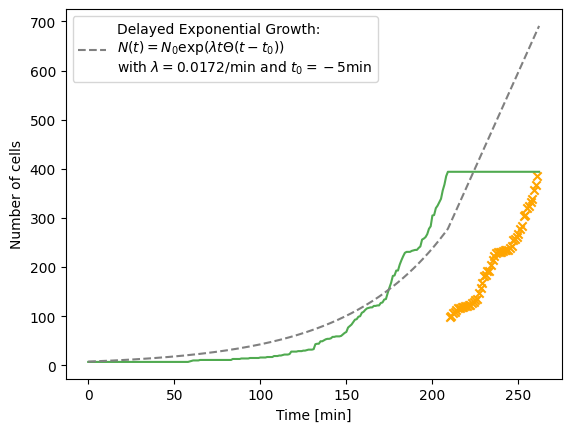

In [27]:
import scipy as sp

# TODO we need to specify these units
minutes_per_iteration = 1

y = np.array([len(np.unique(m)) for m in masks])
x = np.arange(len(y)) * minutes_per_iteration

# Clean up data: Exclude datapoints where next iteration is smaller than previous
current_max = [y[0]]
def filtering(i, current_max):
    if y[i] >= current_max[0]:
        current_max[0] = [y[i]]
        return True
    else:
        return False

filt = np.array([filtering(i, current_max) for i in range(len(y))])
x_nop = x[filt==False]
y_nop = y[filt==False]
x = x[filt]
y = y[filt]

def exp_growth(t, t0, l):
    s = np.maximum(t-t0, 0)
    return y[0] * np.exp(l*s)

popt, _ = sp.optimize.curve_fit(exp_growth, x, y, p0=(50 * minutes_per_iteration, 0.15 / minutes_per_iteration))

fig, ax = plt.subplots()
ax.plot(x, y, color="#50AA50")
ax.scatter(x_nop, y_nop, color="orange", marker="x")
ax.plot(
    x,
    exp_growth(x, *popt),
    label='Delayed Exponential Growth:\n' +
        '$N(t)=N_0 \\text{exp}(\lambda t\Theta(t-t_0))$\n' +
        "with $\lambda={:6.4f}".format(popt[1]) + '/\\text{min}$' +
        " and $t_0={:2.0f}".format(popt[0]) + '\\text{min}$',
    linestyle="--",
    color="gray",
)
ax.set_xlabel("Time [min]")
ax.set_ylabel("Number of cells")
ax.legend()
plt.show()

In [28]:
# Only plot values which have been labelled correctly
pool = mp.Pool()
files_filtered = np.array(files)# np.array(files)[filt]
imgs_filtered = np.array(imgs)# np.array(imgs)[filt]
masks_filtered = np.array(masks)[filt]

_ = list(tqdm.tqdm(pool.imap(
        __plot_iteration_helper,
        zip(files_filtered, imgs_filtered, [m for m in masks_filtered])
    ),
    total=len(files_filtered))
)

 71%|███████   | 211/298 [00:30<00:12,  6.86it/s]


In [18]:
def create_lineage(masks) -> dict:
    lineages = {}
    for n, mask in enumerate(masks[0]):
        print(n, np.sum(mask))
    pass

create_lineage(masks[:50])

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 4.0
61 8.0
62 9.0
63 11.0
64 12.0
65 13.0
66 13.0
67 14.0
68 15.0
69 15.0
70 16.0
71 15.0
72 16.0
73 16.0
74 17.0
75 16.0
76 16.0
77 17.0
78 16.0
79 27.0
80 33.0
81 36.0
82 41.0
83 45.0
84 46.0
85 47.0
86 46.0
87 46.0
88 47.0
89 49.0
90 49.0
91 50.0
92 48.0
93 50.0
94 50.0
95 51.0
96 49.0
97 48.0
98 48.0
99 47.0
100 47.0
101 45.0
102 45.0
103 40.0
104 42.0
105 42.0
106 42.0
107 42.0
108 42.0
109 40.0
110 40.0
111 38.0
112 36.0
113 34.0
114 34.0
115 32.0
116 30.0
117 26.0
118 22.0
119 18.0
120 8.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0

In [7]:
# Make movie
import os
bashcmd = "ffmpeg\
    -pattern_type glob\
    -i 'data/growth-2-marked/*-marked.png'\
    -y\
    -c:v h264\
    -r 15\
    -pix_fmt yuv420p\
    growth-2-markers.mp4"
os.system(bashcmd)

ffmpeg version n7.0.2 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.1 (GCC) 20240805
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libdvdnav --enable-libdvdread --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enabl

0

## Further Steps
1. [ ] Make segmentation stable in time
    1. [ ] Assign identifiers to cells which are persistent in time
    2. [ ] Assign completely new identifiers to cells resulting from division (but link them to their parent cell)
2. [ ] Construct a function which takes a number of cells with position, shape, etc. and returns a  
    prediction depending on their parameters.
    ```python
    def predict_cells(cells: list[Cell]) -> list[Cell]:
        pass
    ```
3. [ ] Compare predictions and actual values and try to determine all the parameters in the 
    `predict_cells` function.